### Load module

In [1]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import os
import torch

def load_text(fpaths, by_lines=False):
    with open(fpaths, "r") as fp:
        if by_lines:
            return fp.readlines()
        else:
            return fp.read()

def load_prompt(prompt):
    return load_text(f"prompts/{prompt}.txt")

/home/clhsieh/miniconda3/envs/minecraft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load model

In [2]:
model_name = 'Qwen2.5-VL-7B-Instruct' # 'Qwen2.5-VL-32B-Instruct-AWQ'  # Qwen2.5-VL-7B-Instruct, Qwen2.5-VL-7B-Instruct-AWQ, Qwen2.5-VL-32B-Instruct, Qwen2.5-VL-32B-Instruct-AWQ
torch_dtype = torch.float16 if 'AWQ' in model_name else 'auto'
# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    f"/nfs/turbo/coe-stellayu/clhsieh/Minecraft/ckpt/Qwen/{model_name}", torch_dtype=torch.float16, device_map="auto"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-7B-Instruct",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processer
processor = AutoProcessor.from_pretrained(f"Qwen/{model_name}")

# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

Loading checkpoint shards: 100%|██████████| 5/5 [00:32<00:00,  6.45s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### Load data and define task

['### Detailed Building Description\n\nThe building appears to be a simple square pit or hole dug into the ground. The edges of the pit are lined with cobblestone blocks, forming a frame around the opening. The interior of the pit is filled with grass blocks, indicating it is not yet fully constructed or is intended to be filled with something else later.\n\n- **Material**: cobblestone, grass\n- **Dimensions**: 4x4x2 (width x height x depth)\n- **Position**: (0, 0, 0) to (4, 0, 4)\n- **Tips**: Ensure the cobblestone blocks are placed evenly along the perimeter to form a solid frame.\n- **Description**: This is the foundation of a square pit, likely intended to be filled with soil or other materials for further construction.\n\n### Structured Reconstruction Information\n\n#### Step 1: Cobblestone Frame\n- **Structure**: Cobblestone Frame\n- **Material**: cobblestone\n- **Number of Materials**: 32 cobblestone blocks\n- **Dimension**: 4x4x2 (width x height x depth)\n- **Position**: (0, 0,

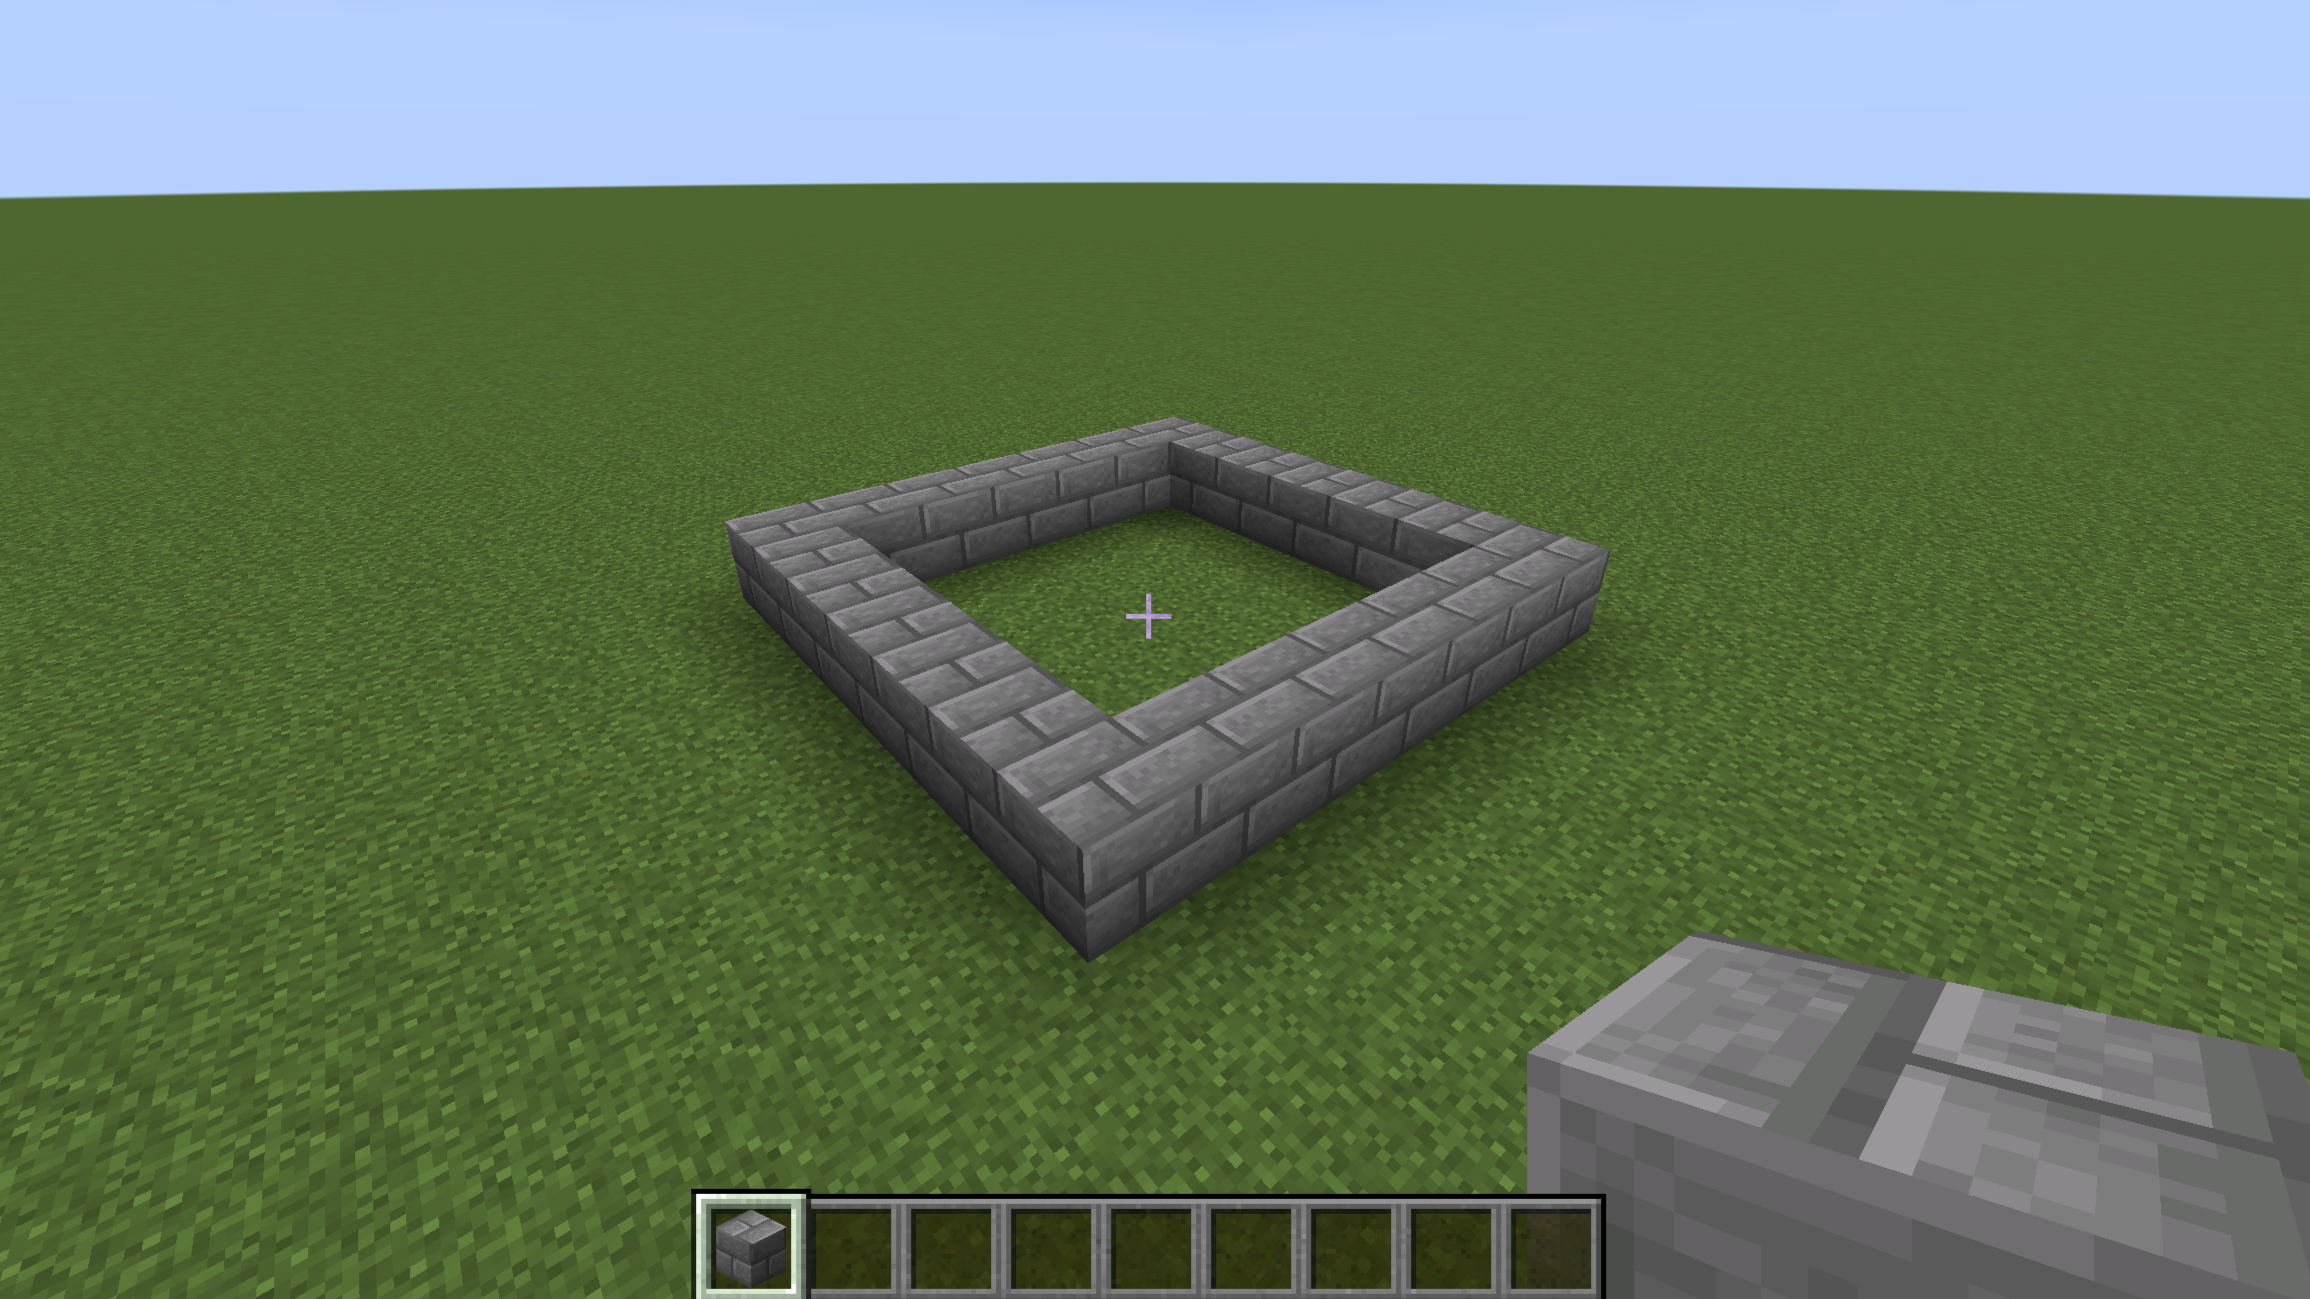

In [3]:
for image_name in ['easy-0.png']: # ['japanese_house.webp', 'incinerator.png', 'easy-0.png', 'easy-1.png', 'easy-2.png', 'easy-3.png', 'easy-4.png', 'easy-5.png']: # 'barn_house.webp', 'castle_wall.webp', 'greek_house.webp', 'mg_nest.png'
# image_name = 'greek_house.webp' # barn_house.webp, castle_wall.webp, greek_house.webp, mg_nest.png, japanese_house.webp, incinerator.png
    # image_name = f'easy-{i}.png'
    folder = 'easy' if 'easy' in image_name else 'mid'
    img_path = f"/nfs/turbo/coe-stellayu/clhsieh/Minecraft/data/{folder}/{image_name}"
    image_name_without_ext = os.path.splitext(os.path.basename(img_path))[0]

    output_dir = f"output/{model_name}/{folder}"
    os.makedirs(output_dir, exist_ok=True)
    output_file_path = f"{output_dir}/{image_name_without_ext}.txt"
    

    building_description_system = load_prompt("building_description_system")
    building_description_query = load_prompt("building_description_query")
    messages = [
        {
            "role": "system",
            "content": [
                {"type": "text", "text": building_description_system},
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": img_path,
                },
                {"type": "text", "text": building_description_query},
            ],
        },
    ]

    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=4800)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    print(output_text)

    # Save the output_text as a txt file with the name of image_name without the file type

    # Save the output_text to the file
    with open(output_file_path, "w") as file:
        file.write(output_text[0])

    from IPython.display import Image, display

    # Display the image
    display(Image(filename=img_path))

### Process task